In [30]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import torch

from utils import load_features_and_labels
from models.gaussian_process import train_gp_model

import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem

### First we load our initial dataset and train a GP model to fit the data

In [2]:
smiles, X, X_p, y = load_features_and_labels('./processed_data/initial_dataset/jtnn_features.csv' ,'./raw_data/photoswitches_jtnn.csv' ,'e_iso_pi')

In [3]:
model, x_scaler, y_scaler = train_gp_model(X, y)


Beginning training loop...

mean R^2: 0.8601 +- 0.0144
mean RMSE: 23.8784 +- 1.4816
mean MAE: 14.8252 +- 0.6878



### With the newly obtained model with a MAE of +- 14 nm, we can start screening our library

In [18]:
# load the JTNN variational autoencoder
import sys
sys.path.append('./FastJTNNpy3/')

from FastJTNNpy3.fast_molvae.sample import load_model
vae_model = load_model('./FastJTNNpy3/data/vocab.txt', './FastJTNNpy3/fast_molvae/vae_model/model.epoch-19')

In [8]:
# function to predict the wavelength using the GP model trained on the JTNN VAE latent space
def predict_wavelength(smiles):
  features = vae_model.encode_from_smiles([smiles])
  features = features.detach().numpy().astype('float')
  output = model.predict_f(features)
  wavelength = y_scaler.inverse_transform(output[0])[0][0]
  return wavelength

In [9]:
# decode a latent space vector into a smiles string
def decode_latent(tree_vec, mol_vec):
  tree_vec = torch.from_numpy(tree_vec.numpy()).float()
  mol_vec = torch.from_numpy(mol_vec.numpy()).float()
  tree_mean = vae_model.T_mean(tree_vec)
  mol_mean = vae_model.G_mean(mol_vec)
  smiles = vae_model.decode(tree_mean, mol_mean, prob_decode=False)
  return smiles

### Here we taking a molecule with one of the highest predicted transition wavelengths in our previous screens as a starting point for the optimization algorithm

In [27]:
# starting smiles
smiles = "Cn1c(C#N)ccc1-c1ccc(N=Nc2ccc(-c3ccc(C#N)n3C)s2)s1"

features = vae_model.encode_from_smiles([smiles])
features = features.detach().numpy().astype('float')
mol = Chem.MolFromSmiles(smiles)
fp1 = AllChem.GetMorganFingerprint(mol, 2)

print('predicted wavelength: ', predict_wavelength(smiles))

predicted wavelength:  444.09740467552996


### Now we start trying to generate a better molecule, based on our initial molecule, with a higher transition wavelength

In [33]:
def maximize_wavelength(n_iter, lr, starting_features, plot=True):
  curr_vec = starting_features
  generated_molecules = []
  wavelenghts = []

  for step in range(n_iter):
    curr_vec_tf = tf.Variable(curr_vec, name='curr_vec')
    with tf.GradientTape() as tape:
      wavelength, _ = model.predict_f(curr_vec_tf)
    grad = tape.gradient(wavelength, curr_vec_tf)
    curr_vec = curr_vec + lr * grad
    generated_molecules.append(curr_vec)
    
    tree_vec, mol_vec = tf.split(curr_vec, num_or_size_splits=2, axis=1)
    new_smiles = decode_latent(tree_vec, mol_vec)
    wavelenghts.append(predict_wavelength(new_smiles))
    
  if plot:
    plt.title('Predicted transition wavelengths of generated molecules')
    plt.xaxis('# of iterations')
    plt.yaxis('Transition wavelength (nm)')
    plt.plot(np.arange(len(wavelenghts)), wavelenghts)
    plt.show()
    
  return generated_molecules, wavelenghts

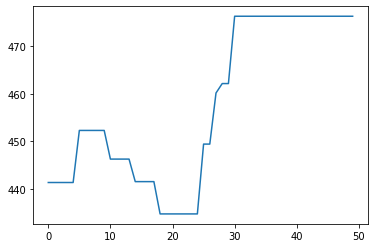

In [34]:
generated_molecules, wavelenghts = maximize_wavelength(50, 2.0, features)

In [ ]:
l, r = 0, n_iter - 1
while l < r - 1:
  mid = int((l + r) / 2)
  new_vec = visited[mid]
  tree_vec, mol_vec = tf.split(new_vec, num_or_size_splits=2, axis=1)
  new_smiles = decode_latent(tree_vec, mol_vec)
  if new_smiles is None:
    r = mid - 1
    continue

  new_mol = Chem.MolFromSmiles(new_smiles)
  fp2 = AllChem.GetMorganFingerprint(new_mol, 2)
  sim = DataStructs.TanimotoSimilarity(fp1, fp2) 
  if sim < sim_cutoff:
      r = mid - 1
  else:
      l = mid

tree_vec, mol_vec = tf.split(visited[l], num_or_size_splits=2, axis=1)
new_smiles = decode_latent(tree_vec, mol_vec)
print(new_smiles)
print(predict_wavelength(new_smiles))  
new_mol = Chem.MolFromSmiles(new_smiles)
fp2 = AllChem.GetMorganFingerprint(new_mol, 2)
sim = DataStructs.TanimotoSimilarity(fp1, fp2) 
